In [1]:
import pandas as pd
from copy import deepcopy
from config import api_key, secret
from pybit.unified_trading import HTTP
from get_candels import get_candels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from config import api_key, secret
from pybit.unified_trading import HTTP
from sklearn.metrics import mean_squared_error

In [2]:
class get_candels:
    def __init__(self, category = "spot", symbol = "BTCUSDT", interval = 60, limit = 1000, start=1672520400000, end=1688072400000):

        self.session = HTTP(api_key=api_key, api_secret=secret, testnet=False)

        self.category = category
        self.symbol = symbol
        self.interval = interval
        self.limit = limit
        self.start = start
        self.end = end


    def get_response(self):

        response = self.session.get_kline(
        category=self.category,
        symbol=self.symbol,
        interval=self.interval,
        start=self.start,
        end=self.end, limit = 1000
        ).get('result')

        return response
    
    def getting_data(self):

        response = self.get_response()
        
        data = pd.DataFrame(response['list'])

        data.rename(columns= {0 : 'time',   
                      1:"open",
                      2: "high",
                      3: "low",
                      4: "close",
                      5 : "volume",
                      6: "turnover"}, inplace=True)
        
        data['time'] = data['time'].apply(lambda x: pd.to_datetime(int(x[:-3]), unit='s'))

        data[["open", "high", "low", "close", "volume", "turnover"]] = data[["open", "high", "low", "close", "volume", "turnover"]].astype(float)

        data['date'] = data['time'].dt.date

        data.sort_values(by='time', ignore_index=True, inplace=True)


        return data

Скачиваем данные

In [3]:
start=1672520400


for i in range(7):
    print(i)
    if i == 0:
        end = start + 3600 * 1000
        gk = get_candels(start= int(start * 1000), end= int(end * 1000))
        data = gk.getting_data()

    else:
        start = deepcopy(end)
        end += 3600 * 1000
        print(start, end)
        gk = get_candels(start= int(start * 1000), end= int(end * 1000))
        d = gk.getting_data()

        data = pd.concat([data, d])


0
1
1676120400 1679720400
2
1679720400 1683320400
3
1683320400 1686920400
4
1686920400 1690520400
5
1690520400 1694120400
6
1694120400 1697720400


In [4]:
data

,time,open,high,low,close,volume,turnover,date
0,2022-12-31 22:00:00,16548.09,16566.11,16471.44,16519.40,157.626338,2.604988e+06,2022-12-31
1,2022-12-31 23:00:00,16519.40,16549.92,16489.43,16541.80,117.408007,1.940086e+06,2022-12-31
2,2023-01-01 00:00:00,16541.80,16545.09,16509.76,16529.01,76.462545,1.263788e+06,2023-01-01
3,2023-01-01 01:00:00,16529.01,16555.95,16525.74,16551.38,43.388160,7.175444e+05,2023-01-01
4,2023-01-01 02:00:00,16551.38,16560.00,16538.48,16547.56,34.393567,5.691448e+05,2023-01-01
...,...,...,...,...,...,...,...,...
995,2023-10-19 09:00:00,28325.23,28408.51,28284.01,28399.52,233.927777,6.633191e+06,2023-10-19
996,2023-10-19 10:00:00,28399.52,28514.68,28376.00,28479.17,575.845020,1.638399e+07,2023-10-19
997,2023-10-19 11:00:00,28479.17,28495.61,28410.00,28452.85,166.232666,4.727775e+06,2023-10-19
998,2023-10-19 12:00:00,28452.85,28583.39,28424.87,28479.99,557.094214,1.587601e+07,2023-10-19


In [5]:
data.reset_index(drop= True, inplace=True)
data.drop_duplicates(subset=['time'], inplace= True)

Ищем максимумы и минимумы

In [6]:
# for local maxima
maxims = argrelextrema(data['close'].values, np.greater)

# for local minima
mins = argrelextrema(data['close'].values, np.less)

In [7]:
max_data = list(maxims[0])
min_data = list(mins[0])

coeff = 0.001

if max_data[0] < min_data[0]:
    max_data = max_data[1::]
if min_data[-1] > max_data[-1]:
    min_data = min_data[:-1]
res_max = []
res_min = []
for i in range(len(max_data)):
    bp = data.iloc[min_data[i]]['close']
    sp = data.iloc[max_data[i]]['close']
    if (sp - bp) - coeff * (bp + sp) > 0:
        res_max.append(max_data[i])
        res_min.append(min_data[i])

In [8]:
classes = []

for i in range(len(data)):
    if i in res_min:
        classes.append(1)
    elif i in res_max:
        classes.append(-1)
    else:
        classes.append(0)

Запишем классы в данные

In [9]:
data['class'] = classes

In [10]:
data

,time,open,high,low,close,volume,turnover,date,class
0,2022-12-31 22:00:00,16548.09,16566.11,16471.44,16519.40,157.626338,2.604988e+06,2022-12-31,0
1,2022-12-31 23:00:00,16519.40,16549.92,16489.43,16541.80,117.408007,1.940086e+06,2022-12-31,0
2,2023-01-01 00:00:00,16541.80,16545.09,16509.76,16529.01,76.462545,1.263788e+06,2023-01-01,0
3,2023-01-01 01:00:00,16529.01,16555.95,16525.74,16551.38,43.388160,7.175444e+05,2023-01-01,0
4,2023-01-01 02:00:00,16551.38,16560.00,16538.48,16547.56,34.393567,5.691448e+05,2023-01-01,0
...,...,...,...,...,...,...,...,...,...
6995,2023-10-19 09:00:00,28325.23,28408.51,28284.01,28399.52,233.927777,6.633191e+06,2023-10-19,0
6996,2023-10-19 10:00:00,28399.52,28514.68,28376.00,28479.17,575.845020,1.638399e+07,2023-10-19,-1
6997,2023-10-19 11:00:00,28479.17,28495.61,28410.00,28452.85,166.232666,4.727775e+06,2023-10-19,0
6998,2023-10-19 12:00:00,28452.85,28583.39,28424.87,28479.99,557.094214,1.587601e+07,2023-10-19,0


Обрежем данные под 1-ю покупку

In [11]:
buy_index = data[data['class'] == 1].index[0]
data = data[buy_index::]
data.shape

(6990, 9)

Разметка нормированной прибыли

In [12]:
indexes  = list(data[data['class'] == 1].index)
indexes.append(data.iloc[-1].name + 1)


comission = 0.001
revenue = []
for i in range(len(indexes) - 1) :
    df = data.loc[indexes[i]:indexes[i+1] - 1]
    rev = []
    for index, row in df.iterrows():
        clas = row['class']
        close = row['close']
        if clas == 1:
            buy = close
            rev.append(0)
        elif clas == 0:
            dohod = (close - buy - (close + buy) * comission) / buy
            rev.append(dohod)
        elif clas == -1:
            norm_dohod = (close - buy - (close + buy) * comission) / buy
            rev.append(norm_dohod)

    if len(rev) != df.shape[0]:
        print(i)
    rev = np.array(rev)/norm_dohod

    revenue.append(rev)

  

Запишем нормированную прибыль в данные

In [13]:
revenue = np.concatenate(revenue)
data['norm_revenue'] = revenue

C:\Users\Павел Карпов\AppData\Local\Temp\ipykernel_10704\1647947869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['norm_revenue'] = revenue


In [14]:
data

,time,open,high,low,close,volume,turnover,date,class,norm_revenue
10,2023-01-01 08:00:00,16525.20,16532.82,16508.50,16513.86,56.835204,9.388235e+05,2023-01-01,1,0.000000
11,2023-01-01 09:00:00,16513.86,16541.26,16505.69,16537.52,46.099953,7.616852e+05,2023-01-01,0,-0.629690
12,2023-01-01 10:00:00,16537.52,16550.90,16532.48,16550.50,57.431614,9.500420e+05,2023-01-01,0,0.239746
13,2023-01-01 11:00:00,16550.50,16556.99,16541.61,16556.11,33.875597,5.606588e+05,2023-01-01,0,0.615519
14,2023-01-01 12:00:00,16556.11,16572.70,16551.51,16561.85,57.047831,9.447997e+05,2023-01-01,-1,1.000000
...,...,...,...,...,...,...,...,...,...,...
6995,2023-10-19 09:00:00,28325.23,28408.51,28284.01,28399.52,233.927777,6.633191e+06,2023-10-19,0,0.180832
6996,2023-10-19 10:00:00,28399.52,28514.68,28376.00,28479.17,575.845020,1.638399e+07,2023-10-19,-1,1.000000
6997,2023-10-19 11:00:00,28479.17,28495.61,28410.00,28452.85,166.232666,4.727775e+06,2023-10-19,0,0.729310
6998,2023-10-19 12:00:00,28452.85,28583.39,28424.87,28479.99,557.094214,1.587601e+07,2023-10-19,0,1.008433


In [15]:
# data.to_csv('E:/Биржа/data/data_with_normed_revenue.csv', index=False)

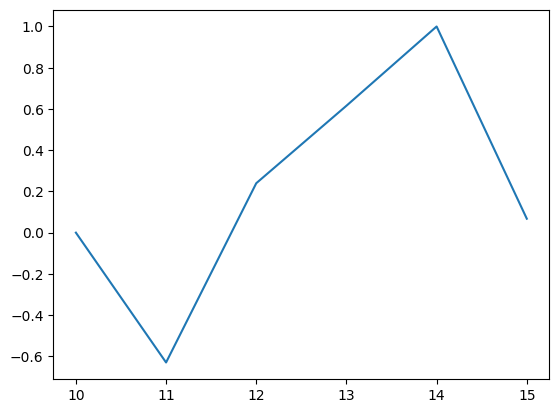

In [16]:
i = 0
plt.plot(data['norm_revenue'].loc[indexes[i]:indexes[i+1] - 1])

Считаем индикаторы, собираем датасет с ними

In [17]:
from calculate_ta_indicators import calculate_ta_indicators
from optimizer import optimization
from ta_strategies import RSI_Strategy, MAKD_Strategy
from united_dfs import united_dfs

e:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
cta = calculate_ta_indicators(data, rsi=14)

In [19]:
d = united_dfs(data, cta)

In [20]:
d.columns

Index(['index', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover',
       'date', 'class', 'norm_revenue', 'macd', 'macdsignal', 'macdhist',
       'macd_diff', 'rsi', 'upperband', 'middleband', 'lowerband', 'aroon_osc',
       'lr_angle', 'hammer', 'shooting_star', 'evening_star', 'morning_star',
       'piersing', 'three_white_soldiers', 'three_black_crowns', 'hanging_man',
       'dark_cloud_clover'],
      dtype='object')

Выделяем таргеты и предикторы

In [21]:
X = d[['date','rsi']]

y = d[['norm_revenue']]

In [22]:
X_train = X[(X['date'] >= pd.to_datetime('2023-01-01').date()) & (X['date'] < pd.to_datetime('2023-07-01').date())][[x for x in X.columns if x not in  ['date']]]
X_test = X[(X['date'] >= pd.to_datetime('2023-07-01').date()) & (X['date'] < pd.to_datetime('2023-08-01').date())][[x for x in X.columns if x not in  ['date']]]
y_train = y.iloc[X_train.index]
y_test = y.iloc[X_test.index]

Попробовал RNN

In [23]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Шаг 1: Подготовка данных
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_dataset = CustomDataset(X_test, y_test)

# Шаг 2: Определение модели
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(2019)

# Hyperparameter settings
TIME_STEP = 10 # RNN time step
INPUT_SIZE = 1 # RNN input size
INIT_LR = 0.02 # Initial learning rate
N_EPOCHS = 100 # Number of training rounds


class RNN(nn.Module):

    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
                         hidden_size=32, # Number of hidden neurons in RNN
                         num_layers=1, # RNN hidden layer number
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h):
        # x (time_step, batch_size, input_size)
        # h (n_layers, batch, hidden_size)
        # out (time_step, batch_size, hidden_size)
        out, h = self.rnn(x, h)
        prediction = self.out(out)
        return prediction, h


model = RNN()
# Шаг 3: Обучение модели
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
h_state = None
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:

        prediction, h_state = model(inputs, h_state) # RNN output (prediction result, hidden state)
        h_state = h_state.detach() # This line is very important, passing down the intermediate state of each output (without gradient)
        loss = criterion(prediction, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [24]:
prediction, h_state = model(test_dataset.X, h_state)

In [25]:
preds = np.ravel(prediction.detach().numpy())

In [26]:
mean_squared_error(preds, y_test.values)

7.338437649040142

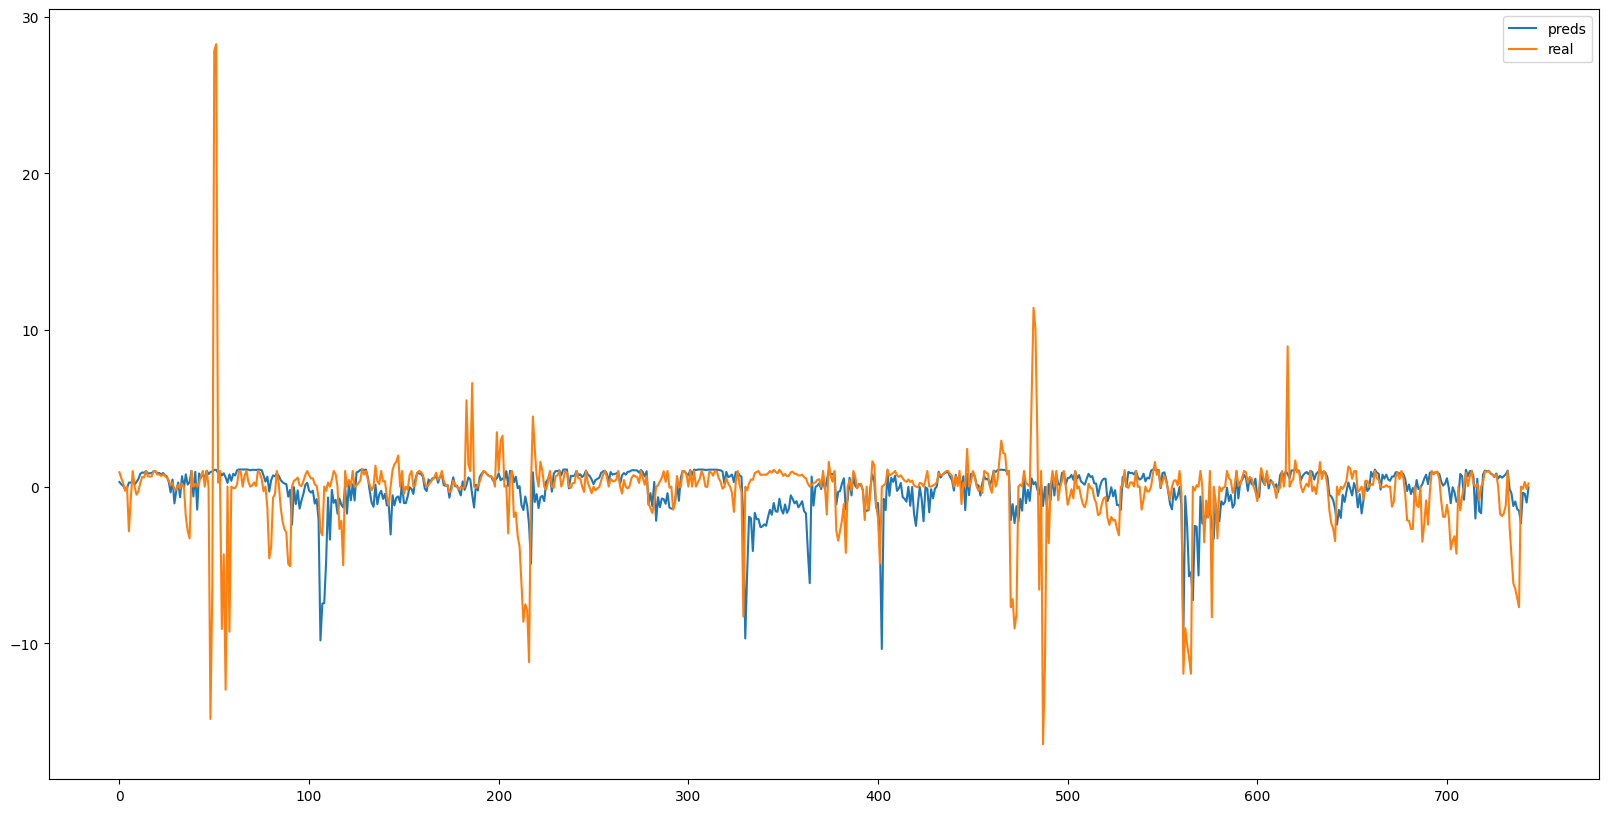

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(preds, label='preds')
plt.plot(y_test.values, label = 'real')
plt.legend()

# Работа с переводом предсказаний в действия робота (надо думать как реализовывать пока можно не смотреть) #

In [930]:
data_for_rev_calculation = X_test
data_for_rev_calculation['norm_revenue'] = preds

In [931]:
data_for_rev_calculation['time'] = d['time'].loc[data_for_rev_calculation.index]
data_for_rev_calculation['high'] = d['high'].loc[data_for_rev_calculation.index]
data_for_rev_calculation['low'] = d['low'].loc[data_for_rev_calculation.index]

In [932]:
data_for_rev_calculation['class'] = data_for_rev_calculation['norm_revenue'].apply(lambda x: int(round(x,0)))

In [933]:
data_for_rev_calculation['buy_price'] = data_for_rev_calculation['close']*data_for_rev_calculation['class']
data_for_rev_calculation['buy_price'] = data_for_rev_calculation['buy_price'].apply(lambda x: None if x == 0 else  (-x if x < 0 else None))

In [934]:
data_for_rev_calculation['sell_price'] = data_for_rev_calculation['close']*data_for_rev_calculation['class']
data_for_rev_calculation['sell_price'] = data_for_rev_calculation['sell_price'].apply(lambda x: None if x == 0 else  (x if x > 0 else None))

In [937]:
data_for_rev_calculation

,open,close,rsi,norm_revenue,high,low,class,buy_price,sell_price
time,,,,,,,,,
2023-07-01 00:00:00,30477.09,30474.00,49.500805,0.016763,30537.71,30425.90,0,NaN,NaN
2023-07-01 01:00:00,30474.00,30449.99,48.510062,-0.794363,30484.79,30384.29,-1,30449.99,NaN
2023-07-01 02:00:00,30449.99,30428.35,47.585632,-0.178895,30535.00,30392.50,0,NaN,NaN
2023-07-01 03:00:00,30428.35,30397.54,46.234712,-0.472152,30444.69,30378.70,0,NaN,NaN
2023-07-01 04:00:00,30397.54,30391.07,45.939768,-0.385365,30418.00,30326.01,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-07-31 19:00:00,29197.03,29162.01,34.544594,-0.877518,29237.96,29115.46,-1,29162.01,NaN
2023-07-31 20:00:00,29162.01,29211.12,40.483986,-1.045879,29258.42,29118.05,-1,29211.12,NaN
2023-07-31 21:00:00,29211.12,29240.54,43.775384,-0.811639,29310.13,29162.00,-1,29240.54,NaN


In [935]:
df = data_for_rev_calculation
df.set_index('time', inplace=True)

e:\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


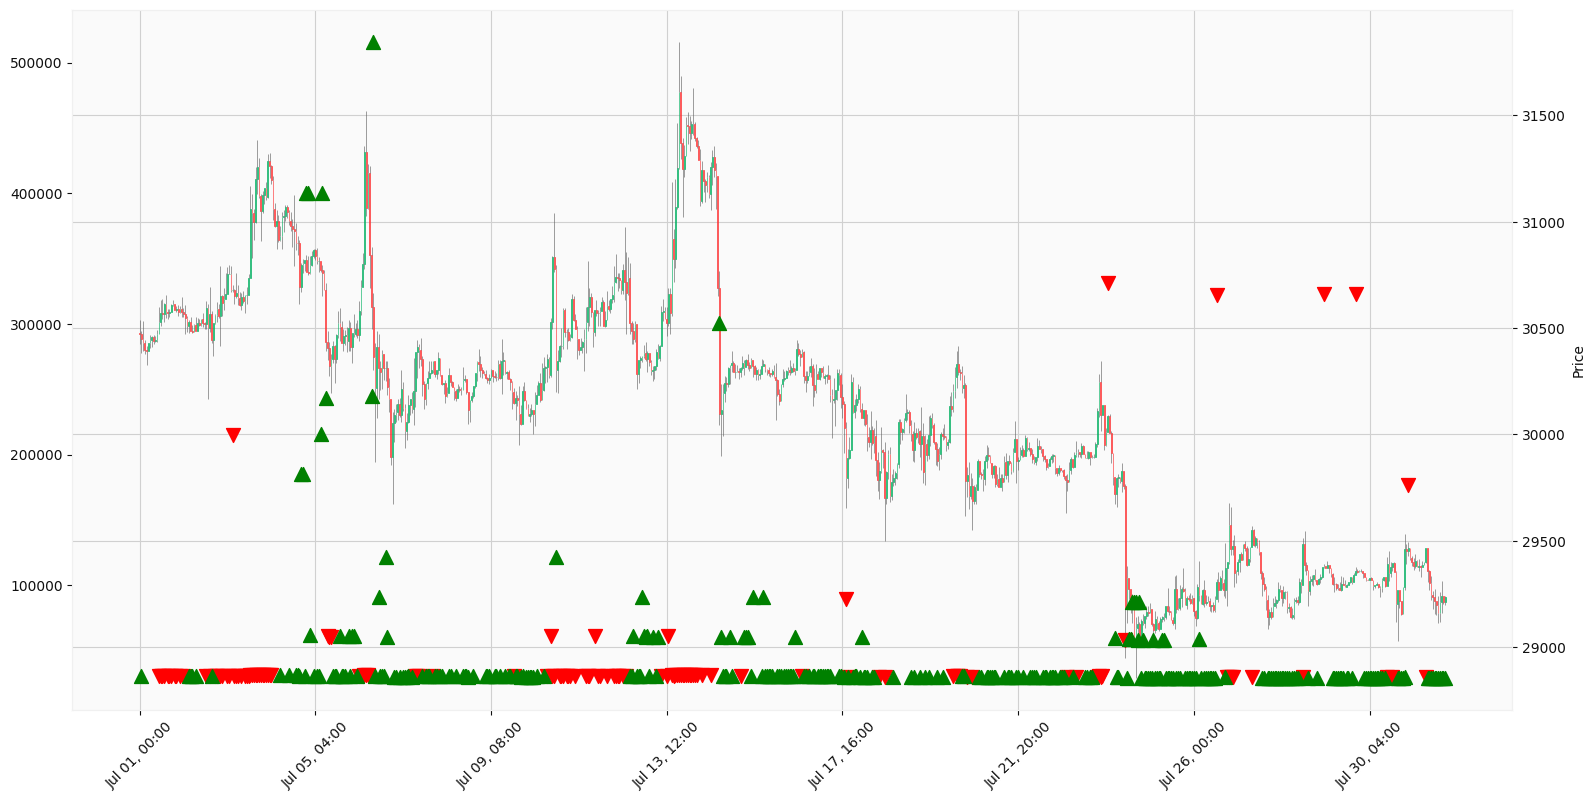

In [936]:
sell_plot = mpf.make_addplot(df['sell_price'],type='scatter',markersize=100,marker='v',color="r")
buy_plot = mpf.make_addplot(df['buy_price'],type='scatter',markersize=100,marker='^',color="g")
mpf.plot(df, type = 'candle', style='yahoo', figsize=(20,10), addplot=[sell_plot, buy_plot])

In [796]:
data_for_rev_calculation['class'].value_counts()

class
 0    675
 1     39
-1     30
Name: count, dtype: int64

In [797]:
data_for_rev_calculation

,open,close,rsi,class,high,low,buy_price,sell_price
time,,,,,,,,
2023-07-01 00:00:00,30477.09,30474.00,50.568396,0,30537.71,30425.90,NaN,NaN
2023-07-01 01:00:00,30474.00,30449.99,48.423710,0,30484.79,30384.29,NaN,NaN
2023-07-01 02:00:00,30449.99,30428.35,46.396822,0,30535.00,30392.50,NaN,NaN
2023-07-01 03:00:00,30428.35,30397.54,43.438325,0,30444.69,30378.70,NaN,NaN
2023-07-01 04:00:00,30397.54,30391.07,42.783591,0,30418.00,30326.01,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-07-31 19:00:00,29197.03,29162.01,24.596076,0,29237.96,29115.46,NaN,NaN
2023-07-31 20:00:00,29162.01,29211.12,36.793028,0,29258.42,29118.05,NaN,NaN
2023-07-31 21:00:00,29211.12,29240.54,43.094948,0,29310.13,29162.00,NaN,NaN


In [798]:
buy_index = data_for_rev_calculation[data_for_rev_calculation['class'] == 1].index[0]
data_for_rev_calculation = data_for_rev_calculation.loc[buy_index::]

In [ ]:
data_for_rev_calculation['time'] = d['time'].iloc[data_for_rev_calculation.index]

In [800]:
data_for_rev_calculation.reset_index(inplace=True)

In [801]:
from testing_robot import robot

In [802]:
qty = 1
init_sum = 100000
bot = robot(cash=init_sum)

open_p = []
open_d = []

close_p = []
close_d = []

transactions = 0
mistakes = 0

comission = 0.001

buy = False
sell = True

for index,row in data_for_rev_calculation.iterrows():
    points = row['class']
    price = row['close']

    if (points > 0) and (not buy):
        b_p = price
        bot.buy(qty=qty, price=b_p)

        bot.cash -= b_p * comission

        open_p.append(b_p)
        open_d.append(row['time'])
        
        buy = not buy
        sell = not sell

        print(f"Buy {price}")
        
    if (points) < 0 and (not sell):
        s_p = price
        bot.sell(qty=qty, price=s_p)
        bot.cash -= s_p * comission
        close_d.append(row['time'])

        buy = not buy
        sell = not sell 

        transactions += 1
        revenue = (s_p - b_p - (s_p + b_p)*comission) / b_p * 100
        if revenue < 0:
            mistakes+=1
        
        print(f"sell {price}")
        print(f"revenue {revenue}")

        close_p.append(s_p)

Buy 30434.95
sell 30801.0
revenue 1.0015263701763901
Buy 30219.41
sell 30385.7
revenue 0.34972519317882406
Buy 30237.32
sell 30244.02
revenue -0.17786410964992688
Buy 30160.0
sell 30527.99
revenue 1.0189058687002706
Buy 30097.81
sell 30403.1
revenue 0.8133119652227097
Buy 30255.52
sell 30288.0
revenue -0.0927550410635826
Buy 30178.01
sell 30245.99
revenue 0.025038098933638113
Buy 30104.0
sell 30102.35
revenue -0.20547551820356583
Buy 30042.81
sell 30268.51
revenue 0.5505100221983134
Buy 29782.0
sell 30112.01
revenue 0.906977335303198
Buy 30092.87
sell 30140.0
revenue -0.04354144353795095
Buy 30008.0
sell 29459.0
revenue -2.0276826179685417


In [803]:
buy = pd.DataFrame({'time' : open_d, 'buy_price' : open_p})
sell = pd.DataFrame({'time' : close_d, 'sell_price' : close_p})

buy.set_index('time', inplace=True)
sell.set_index('time', inplace=True)

In [804]:
import mplfinance as mpf

In [ ]:
df = d.loc[data_for_rev_calculation.index]
df.set_index('time', inplace=True)
df = pd.merge(df, buy, on='time', how='left')
df = pd.merge(df, sell, on='time', how='left')
sell_plot = mpf.make_addplot(df['sell_price'],type='scatter',markersize=100,marker='v',color="r")
buy_plot = mpf.make_addplot(df['buy_price'],type='scatter',markersize=100,marker='^',color="g")
mpf.plot(df, type = 'candle', style='yahoo', figsize=(20,10), addplot=[sell_plot, buy_plot])

In [806]:
transactions

12

In [807]:
mistakes

5

In [808]:
mistakes/transactions

0.4166666666666667

In [809]:
bot.qty

0

In [810]:
(bot.qty * data_for_rev_calculation.iloc[-1]['close'] + bot.cash - init_sum)/init_sum *100

0.6403796299999958

In [811]:
bot.qty * data_for_rev_calculation.iloc[-1]['close'] + bot.cash

100640.37963